<a href="https://colab.research.google.com/github/ibader85/AdvancedAnalytics/blob/main/19_Recurrent_Neural_Networks_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

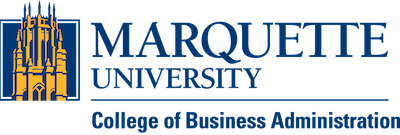

# BUAN 4061: Advanced Business Analytics
# Recurrent Neural Networks 1

Instructor: Dr. Badar Al Lawati

**Acknowledgment**: This material is based on the content created by `Dr. Kambiz Saffarizadeh`

---

A basic neural network (what we saw before).

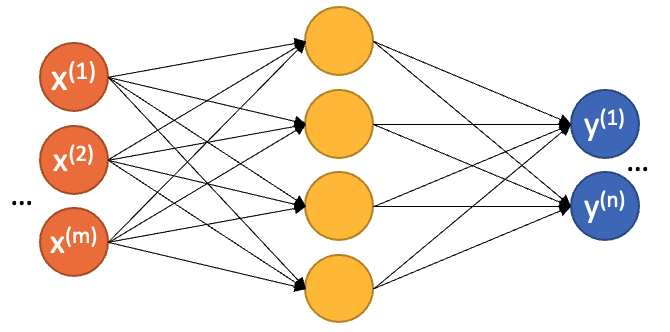

Let's represent the hidden layers by a single box (a black-box!).

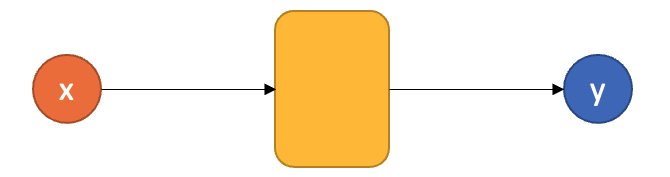

Let's rotate the figure and repeat it for each time step.

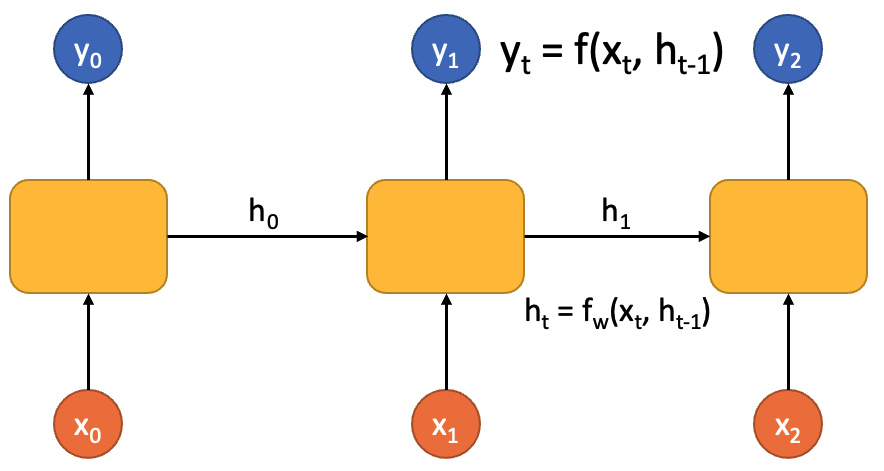

Let's create a model like this in the context of natural language processing...

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import string

# Data

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
!wget https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json

--2024-04-11 21:38:47--  https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5616834 (5.4M) [text/plain]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.36M  --.-KB/s    in 0.07s   

2024-04-11 21:38:47 (72.0 MB/s) - ‘sarcasm.json’ saved [5616834/5616834]



In [4]:
with open("sarcasm.json", 'r') as f:
    dataset = json.load(f)

In [5]:
dataset[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [6]:
def clean_document(document):
  document = document.lower()
  document = document.replace(',', ' , ')
  document = document.replace('.', ' . ')
  document = document.replace('-', ' - ')
  document = document.replace('/', ' / ')
  soup = BeautifulSoup(document)
  document = soup.get_text()
  words = document.split()
  filtered_document = ''
  for word in words:
    word = word.translate(table)
    if word not in stopwords:
      filtered_document = filtered_document + word + ' '
  return filtered_document

In [7]:
documents = []
labels = []
urls = []

for item in dataset:
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])
  document = clean_document(item['headline'])
  documents.append(document)

<ipython-input-6-168d8e305f25>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(document)


# Vectorization

In [8]:
vocab_size = 2000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [9]:
training_docs = documents[0:training_size]
validation_docs = documents[training_size:]

training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_docs)
word_index = tokenizer.word_index

In [11]:
training_sequences = tokenizer.texts_to_sequences(training_docs)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

In [12]:
validation_sequences = tokenizer.texts_to_sequences(validation_docs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

In [13]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

# Model

In [14]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          32000     
                                                                 
 bidirectional (Bidirection  (None, 200)               93600     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                4824      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 130449 (509.57 KB)
Trainable params: 130449 (509.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


FYI: Inside each LSTM cell may look like the following figure.

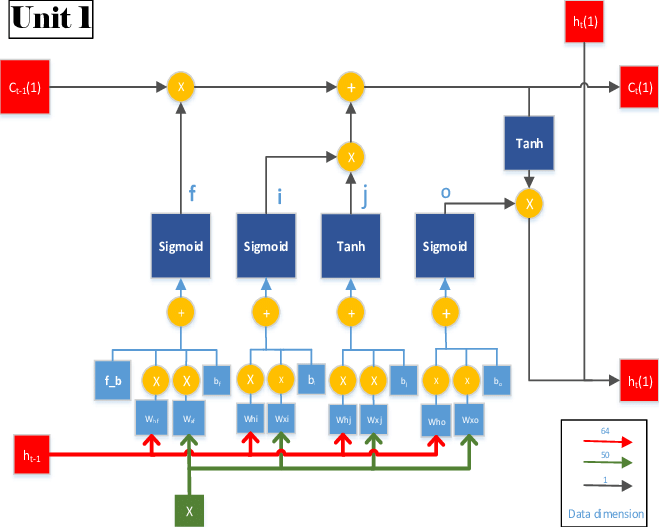

Credit: Wen, S., Wei, H., Yang, Y., Guo, Z., Zeng, Z, 2019 "Memristive LSTM Network for Sentiment Analysis," IEEE TRANSACTIONS ON SYSTEMS MAN AND CYBERNETICS: SYSTEMS

In [16]:
history1 = model1.fit(training_padded, training_labels, epochs=20, validation_data=(validation_padded, validation_labels))

# To reduce the wait time in the classroom, we run the model with only 20 epochs.
# But we need 100-150 epochs to better investigate the learning curves.

Epoch 1/20
719/719 [==============================] - 26s 28ms/step - loss: 0.8578 - accuracy: 0.7015 - val_loss: 0.4968 - val_accuracy: 0.7692
Epoch 2/20
719/719 [==============================] - 10s 14ms/step - loss: 0.4596 - accuracy: 0.7902 - val_loss: 0.5102 - val_accuracy: 0.7406
Epoch 3/20
719/719 [==============================] - 10s 14ms/step - loss: 0.4358 - accuracy: 0.8016 - val_loss: 0.4805 - val_accuracy: 0.7762
Epoch 4/20
719/719 [==============================] - 11s 15ms/step - loss: 0.4154 - accuracy: 0.8132 - val_loss: 0.4699 - val_accuracy: 0.7884
Epoch 5/20
719/719 [==============================] - 9s 12ms/step - loss: 0.3910 - accuracy: 0.8259 - val_loss: 0.4519 - val_accuracy: 0.7910
Epoch 6/20
719/719 [==============================] - 9s 13ms/step - loss: 0.3727 - accuracy: 0.8357 - val_loss: 0.4590 - val_accuracy: 0.7916
Epoch 7/20
719/719 [==============================] - 9s 13ms/step - loss: 0.3603 - accuracy: 0.8428 - val_loss: 0.4597 - val_accuracy: 0.

In [17]:
def plot_graphs(history, set_name):
  plt.plot(history.history[set_name])
  plt.plot(history.history['val_' + set_name])
  plt.xlabel("Epochs")
  plt.ylabel(set_name)
  plt.legend([set_name, 'val_' + set_name])
  plt.show()

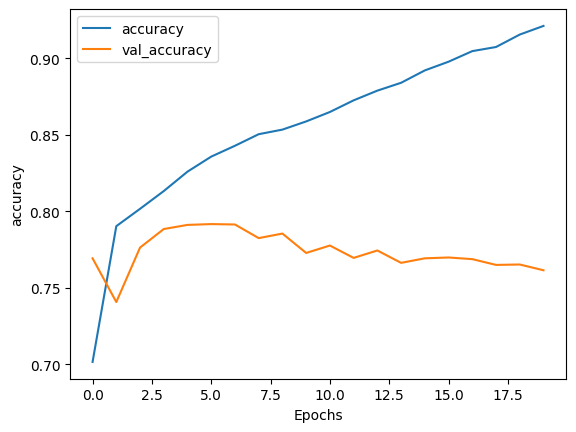

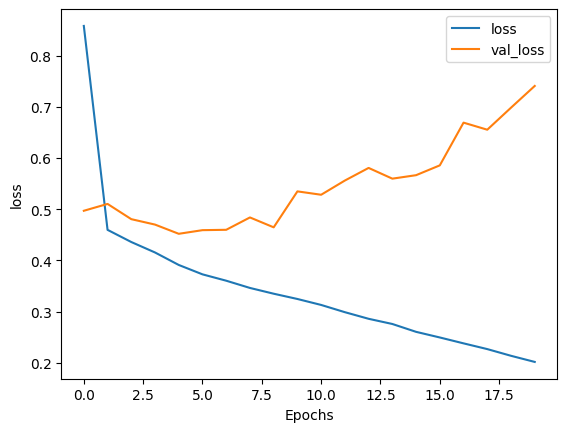

In [18]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

# Revised Model

In [19]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=0.000008),
               metrics = ['accuracy'])

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          32000     
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 200)         93600     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 24)                4824      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 371249 (1.42 MB)
Trainable params: 37124

In [21]:
history2 = model2.fit(training_padded, training_labels, epochs=20, validation_data=(validation_padded, validation_labels))

# To reduce the wait time in the classroom, we run the model with only 20 epochs.
# But we need 100-150 epochs to better investigate the learning curves.

Epoch 1/20
719/719 [==============================] - 31s 31ms/step - loss: 0.6886 - accuracy: 0.5549 - val_loss: 0.6830 - val_accuracy: 0.5700
Epoch 2/20
719/719 [==============================] - 17s 23ms/step - loss: 0.6847 - accuracy: 0.5596 - val_loss: 0.6815 - val_accuracy: 0.5700
Epoch 3/20
719/719 [==============================] - 15s 21ms/step - loss: 0.6831 - accuracy: 0.5596 - val_loss: 0.6791 - val_accuracy: 0.5700
Epoch 4/20
719/719 [==============================] - 15s 21ms/step - loss: 0.6796 - accuracy: 0.5596 - val_loss: 0.6742 - val_accuracy: 0.5697
Epoch 5/20
719/719 [==============================] - 16s 22ms/step - loss: 0.6617 - accuracy: 0.5942 - val_loss: 0.6437 - val_accuracy: 0.6220
Epoch 6/20
719/719 [==============================] - 16s 22ms/step - loss: 0.6363 - accuracy: 0.6340 - val_loss: 0.6274 - val_accuracy: 0.6395
Epoch 7/20
719/719 [==============================] - 15s 21ms/step - loss: 0.6177 - accuracy: 0.6537 - val_loss: 0.6094 - val_accuracy:

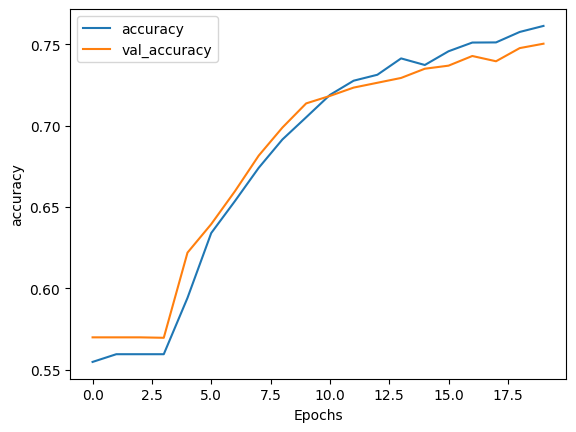

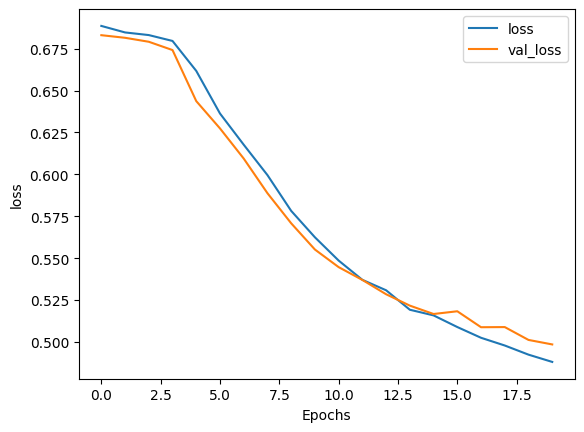

In [22]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

# Using the Models

In [23]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

In [24]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
predictions1 = model1.predict(test_padded)
predictions1

1/1 [==============================] - 1s 710ms/step


array([[0.01177344],
       [0.5187794 ],
       [0.9957034 ],
       [0.9981055 ]], dtype=float32)

In [26]:
predictions2 = model2.predict(test_padded)
predictions2

1/1 [==============================] - 1s 1s/step


array([[0.3121652 ],
       [0.320913  ],
       [0.87624884],
       [0.9036458 ]], dtype=float32)

# Saving the Embeddings

In [27]:
weights1 = model1.layers[0].get_weights()[0]

In [28]:
weights2 = model2.layers[0].get_weights()[0]

In [29]:
weights1.shape

(2000, 16)

In [30]:
reverse_word_index = {}

for (key, value) in word_index.items():
  reverse_word_index[value] = key

# Alternative code:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [31]:
import pandas as pd

In [32]:
df1 = pd.DataFrame(weights1)
df1['word'] = [reverse_word_index[word_num] for word_num in range(1, vocab_size+1)]
df1 = df1.set_index('word')
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
word,,,,,,,,,,,,,,,,
<OOV>,0.043271,-0.009717,0.031183,-0.052500,-0.030430,0.086828,0.042811,0.049701,-0.102484,0.037209,0.028898,0.034859,-0.127539,-0.040297,-0.005099,-0.025658
new,-0.059981,-0.018526,-0.031526,0.045353,0.054170,-0.065786,0.008552,0.024943,-0.030295,-0.023357,0.006744,-0.035103,0.002206,-0.025222,0.011917,-0.035304
trump,0.010762,-0.094171,0.024360,0.072037,0.011492,0.025241,-0.063947,-0.047259,0.013596,0.026039,-0.044453,-0.015675,0.022088,0.098194,0.081397,-0.162232
man,0.089708,0.126439,0.303401,-0.079954,-0.275770,0.239588,0.151957,0.029539,-0.095242,0.177969,0.205276,0.198855,0.020117,-0.068359,0.013499,0.114547
not,-0.181118,-0.231169,-0.140999,0.109338,0.139774,-0.292901,-0.128840,-0.040759,0.205046,-0.147219,-0.107389,-0.195845,0.127594,0.152444,0.213423,-0.289929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
laid,0.060231,0.052648,0.139039,-0.031957,-0.252966,0.302937,0.041231,0.021684,-0.049520,0.118437,0.283443,0.198915,-0.093064,-0.009072,-0.203242,0.181572
add,0.136046,-0.005559,0.140075,-0.122880,-0.029901,-0.194703,0.072669,0.176997,0.134988,0.180189,-0.227535,-0.093668,0.064936,0.021598,0.210971,-0.303885
communities,-0.152407,-0.059650,-0.095762,0.237759,0.011143,-0.270282,-0.161564,-0.131805,0.254904,-0.074992,-0.188339,-0.051604,0.331974,0.112236,0.212067,-0.028476


In [33]:
df2 = pd.DataFrame(weights2)
df2['word'] = [reverse_word_index[word_num] for word_num in range(1, vocab_size+1)]
df2 = df2.set_index('word')
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
word,,,,,,,,,,,,,,,,
<OOV>,0.020773,-0.025114,-0.024905,0.026587,0.043448,-0.008144,0.022383,0.022793,0.017658,0.019921,0.014543,0.025134,-0.026682,0.025933,0.043525,-0.028047
new,0.041512,0.002123,0.036933,0.017773,0.043794,-0.020004,0.037767,0.028984,0.009264,0.014019,-0.024758,0.032959,-0.022523,-0.000789,-0.056129,-0.032641
trump,-0.005405,0.018490,-0.038880,-0.022847,-0.011910,0.012495,0.043612,-0.023713,0.030445,-0.037721,-0.005187,-0.000366,0.031297,-0.024973,0.024486,0.007760
man,0.003721,-0.078703,-0.054211,-0.017140,-0.013606,0.074928,0.011318,-0.061658,-0.070727,0.044200,0.000933,0.022896,-0.075736,-0.015430,0.037883,-0.064366
not,-0.079757,0.002102,0.001204,0.040558,-0.062426,0.007664,0.053168,0.080368,-0.008731,-0.071799,-0.022784,-0.071088,0.011630,-0.053486,0.006000,0.051312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
laid,0.043905,-0.049660,-0.035287,0.014636,0.042816,0.052452,-0.038894,0.039360,0.032457,0.028797,0.029445,0.026762,-0.018474,0.032706,-0.001045,-0.034370
add,-0.050164,0.024554,0.047693,0.017093,0.040874,-0.040552,-0.009333,0.007482,0.004871,-0.049527,-0.016670,-0.041840,0.012676,-0.049920,-0.012276,-0.028486
communities,0.033083,-0.017798,-0.019824,0.001363,-0.012961,-0.003541,-0.037640,-0.025797,0.056201,-0.005289,-0.045781,0.000891,0.013747,0.026657,-0.026722,-0.014087


In [34]:
from scipy import spatial

In [35]:
1 - spatial.distance.cosine(df1.loc['trump'], df1.loc['trump'])

1

Model 1

In [36]:
1 - spatial.distance.cosine(df1.loc['biden'], df1.loc['sanders'])

0.6775287985801697

In [37]:
1 - spatial.distance.cosine(df1.loc['biden'], df1.loc['trump'])

-0.3353695869445801

Model 2

In [38]:
1 - spatial.distance.cosine(df2.loc['biden'], df2.loc['sanders'])

0.29249387979507446

In [39]:
1 - spatial.distance.cosine(df2.loc['biden'], df2.loc['trump'])

-0.21550728380680084